![intro](assets/intro.jpg)

# Sommaire

1. [Nettoyage et description des données sources](#nettoyage)
2. [Correction des données de consommation mensuelles de l'effet température](#q1)
3. [Désaisonnalisation par moyennes mobiles](#q2)
4. [Prévision de la consommation](#q3)
    1. [Méthode de Holt Winters](#q3-1)     
    2. [Méthode SARIMA](#q3-2)
    3. [Prévision des consommations pour l'année 2020](#pred_fin)

<div id="nettoyage" style="float:left; padding:5px; background: black; width:100%; border-bottom: 2px solid #e3a51a;"><img src="assets/logo_small.png" style="float:left; margin-right:10px; height:40px"/><h1 style="float:left; margin-top:10px; color:white; font-family:Helvetica; font-variant: small-caps;">Nettoyage et description des données sources</h1></div>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

## <font color="#e3a51a" style="font-family:Helvetica; font-variant: small-caps;">Données mensuelles de consommation totale d'électricité en énergie</font>

Ces données ont été téléchargées sur la page https://www.rte-france.com/eco2mix/telecharger-les-indicateurs.     
Nous aurons besoin, dans ce jeu de données, de la consommation totale en energie.

In [2]:
df_conso = pd.read_csv("datas/eCO2mix_RTE_energie_M.csv", encoding="latin_1", header=0, sep=";", parse_dates=[0], index_col="Mois")
df_conso.head()

,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,Production éolien,...,Production bioénergies,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique
Mois,,,,,,,,,,,,,,,,,,,,,
2012-01-01,Données définitives,France,57177,42811.0,5399,741.0,691,3967,6741,1587,...,514,51086,5371.0,7043.0,1672.0,929.0,724.0,1581.0,2195.0,-59.0
2012-02-01,Données définitives,France,54419,38661.0,8721,2511.0,1309,4901,5244,1123,...,454,54476,-715.0,4504.0,5220.0,-798.0,-309.0,1244.0,1579.0,-2430.0
2012-03-01,Données définitives,France,48583,37549.0,5276,1435.0,666,3175,3894,977,...,531,43156,4888.0,7042.0,2153.0,583.0,330.0,1742.0,2235.0,-1.0
2012-04-01,Données définitives,France,44192,33100.0,3484,1655.0,486,1343,5302,1572,...,405,40176,3447.0,5762.0,2314.0,547.0,-9.0,1271.0,1670.0,-31.0
2012-05-01,Données définitives,France,40433,29058.0,1772,854.0,368,549,7706,974,...,469,35257,4425.0,6391.0,1965.0,693.0,251.0,1341.0,1060.0,1079.0


In [3]:
df_conso.columns

Index(['Qualité', 'Territoire', 'Production totale', 'Production nucléaire',
       'Production thermique totale', 'Production thermique charbon',
       'Production thermique fioul', 'Production thermique gaz',
       'Production hydraulique', 'Production éolien', 'Production solaire',
       'Production bioénergies', 'Consommation totale', 'Solde exportateur',
       'Echanges export', 'Echanges import', 'Echanges avec le Royaume-Uni',
       'Echanges avec l'Espagne', 'Echanges avec l'Italie',
       'Echanges avec la Suisse', 'Echanges avec l'Allemagne et la Belgique'],
      dtype='object')

In [4]:
df_conso = df_conso[["Territoire","Qualité","Consommation totale"]]
df_conso.head()

,Territoire,Qualité,Consommation totale
Mois,,,
2012-01-01,France,Données définitives,51086
2012-02-01,France,Données définitives,54476
2012-03-01,France,Données définitives,43156
2012-04-01,France,Données définitives,40176
2012-05-01,France,Données définitives,35257


In [5]:
df_conso.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1221 entries, 2012-01-01 to 2020-09-01
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Territoire           1221 non-null   object
 1   Qualité              1221 non-null   object
 2   Consommation totale  1221 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 38.2+ KB


Ce jeu de données ne semble pas contenir de *null*, cependant des agglomérats semblent être présents *(France)*.

In [6]:
df_conso.describe(include = "all")

,Territoire,Qualité,Consommation totale
count,1221,1221,1221.000000
unique,13,2,NaN
top,France,Données définitives,NaN
freq,105,948,NaN
mean,NaN,NaN,6006.176085
std,NaN,NaN,10678.691936
min,NaN,NaN,0.000000
25%,NaN,NaN,1789.000000
50%,NaN,NaN,2938.000000
75%,NaN,NaN,4508.000000


In [7]:
df_conso["Territoire"].unique()

array(['France', 'Grand-Est', 'Nouvelle-Aquitaine',
       'Auvergne-Rhône-Alpes', 'Bourgogne-Franche-Comté', 'Bretagne',
       'Centre-Val de Loire', 'Ile-de-France', 'Occitanie', 'Normandie',
       'Hauts-de-France', 'PACA', 'Pays-de-la-Loire'], dtype=object)

Nous remarquons dans cette liste des régions représentées que **la Corse est absente**. Si ces données sont présentes dans les autres jeux de données utilisés, nous les calculerons donc.

In [8]:
df_conso_france = df_conso[df_conso["Territoire"]=="France"]
df_conso_regions = df_conso[df_conso["Territoire"]!="France"]

In [9]:
df_conso_france.head()

,Territoire,Qualité,Consommation totale
Mois,,,
2012-01-01,France,Données définitives,51086
2012-02-01,France,Données définitives,54476
2012-03-01,France,Données définitives,43156
2012-04-01,France,Données définitives,40176
2012-05-01,France,Données définitives,35257


In [10]:
df_conso_regions.head()

,Territoire,Qualité,Consommation totale
Mois,,,
2013-01-01,Grand-Est,Données définitives,0
2013-01-01,Nouvelle-Aquitaine,Données définitives,0
2013-01-01,Auvergne-Rhône-Alpes,Données définitives,0
2013-01-01,Bourgogne-Franche-Comté,Données définitives,0
2013-01-01,Bretagne,Données définitives,0


In [11]:
#Verification des consommations à 0
df_conso_regions[df_conso_regions["Consommation totale"]==0].groupby(by="Mois").nunique()

,Territoire,Qualité,Consommation totale
Mois,,,
2013-01-01,12,1,1
2013-02-01,12,1,1
2013-03-01,12,1,1
2013-04-01,12,1,1
2013-05-01,12,1,1
2013-06-01,12,1,1
2013-07-01,12,1,1
2013-08-01,12,1,1
2013-09-01,12,1,1


Les données pour 2012 et 2013 au niveau régionnal sont donc absentes.

In [12]:
df_conso_regions = df_conso_regions[df_conso_regions.index.map(pd.to_datetime)>pd.to_datetime('2013-12-01')]
df_conso_regions.head()

,Territoire,Qualité,Consommation totale
Mois,,,
2014-01-01,Grand-Est,Données définitives,4594
2014-01-01,Nouvelle-Aquitaine,Données définitives,4501
2014-01-01,Auvergne-Rhône-Alpes,Données définitives,6693
2014-01-01,Bourgogne-Franche-Comté,Données définitives,2158
2014-01-01,Bretagne,Données définitives,2390


In [13]:
df_conso_regions.describe(include="all")

,Territoire,Qualité,Consommation totale
count,972,972,972.000000
unique,12,2,NaN
top,Pays-de-la-Loire,Données définitives,NaN
freq,81,720,NaN
mean,NaN,NaN,3258.083333
std,NaN,NaN,1501.364035
min,NaN,NaN,1170.000000
25%,NaN,NaN,1973.250000
50%,NaN,NaN,2970.500000
75%,NaN,NaN,4220.500000


On remarque à présent que les données sembles cohérentes. Nous allons vérifier s'il y a encore des données manquantes puis les afficher visuellement pour vérifier.     
Pour information, **les consommations sont exprimées en TWh**.

In [14]:
df_conso_regions.groupby(by=["Territoire"]).count()

,Qualité,Consommation totale
Territoire,,
Auvergne-Rhône-Alpes,81,81
Bourgogne-Franche-Comté,81,81
Bretagne,81,81
Centre-Val de Loire,81,81
Grand-Est,81,81
Hauts-de-France,81,81
Ile-de-France,81,81
Normandie,81,81
Nouvelle-Aquitaine,81,81


Nous constatons donc que nous avons le même nombre de données pour chaque région.    
**Affichons à présent la projection en lineplot** :

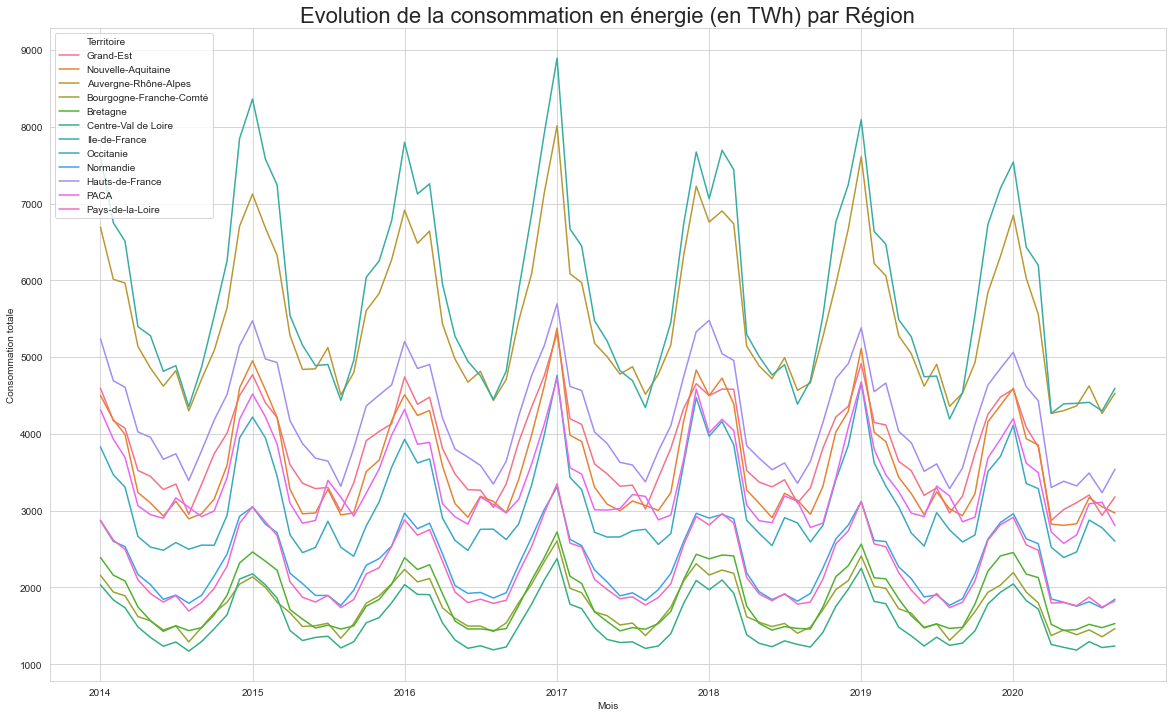

In [15]:
fig = plt.figure(figsize=(20,12))
sns.lineplot(data=df_conso_regions, x=df_conso_regions.index,  y="Consommation totale", hue="Territoire")
plt.title("Evolution de la consommation en énergie (en TWh) par Région", fontsize=22)
plt.show()

Comme nous pouvions nous y attendre, **nous visualisons l'effet saisonnier sur la consommation totale**. Les courbes des différentes régions de France suivent cependant la meme tendance qui semble être plûtot linéaire.

**Nous allons également ploter les données "France"** :

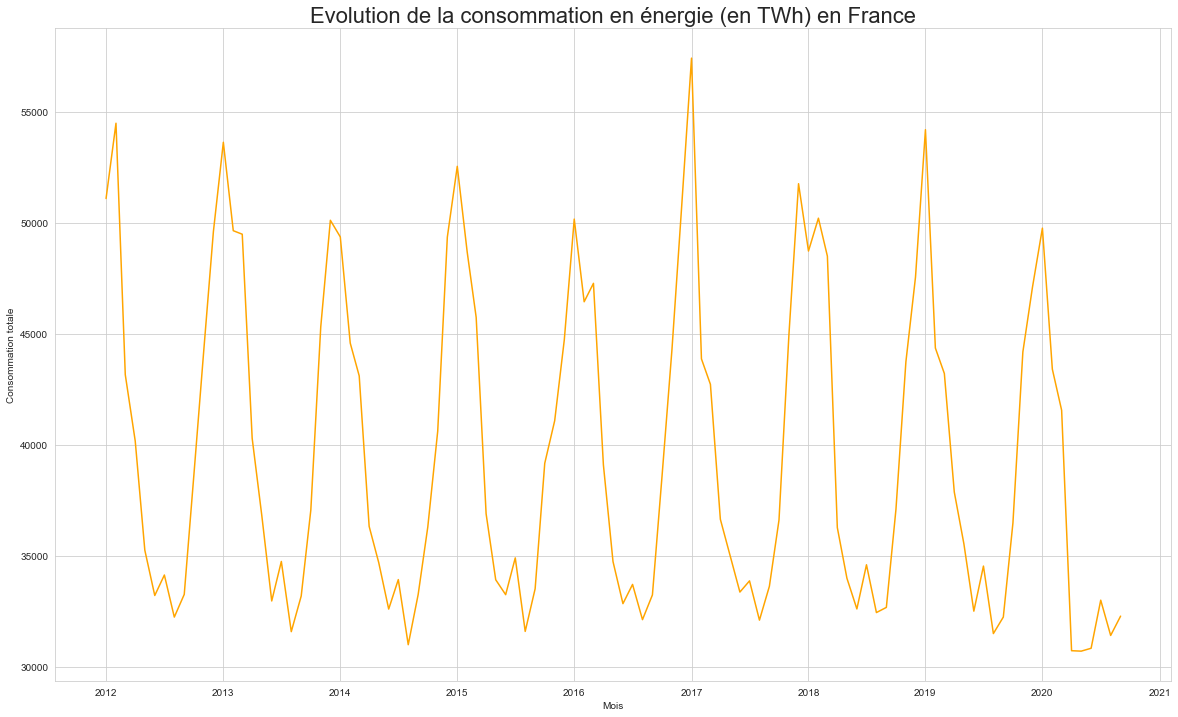

In [16]:
fig = plt.figure(figsize=(20,12))
sns.lineplot(data=df_conso_france, x=df_conso_france.index,  y="Consommation totale", color="orange")
plt.title("Evolution de la consommation en énergie (en TWh) en France", fontsize=22)
plt.show()

## <font color="#e3a51a" style="font-family:Helvetica; font-variant: small-caps;">Données météo utilisées pour corriger les données de l'effet température</font>

Ces datasets ont été téléchargés sur le lien https://cegibat.grdf.fr/simulateur/calcul-dju pour les données des stations de chaque chef lieu de Région.

In [17]:
list_dju_file = os.listdir('datas/DJU')
print(list_dju_file)

['calcul_DJU_Auvergne-Rhône-Alpes.xlsx', 'calcul_DJU_Bourgogne-Franche-Comté.xlsx', 'calcul_DJU_Bretagne.xlsx', 'calcul_DJU_Centre-Val de Loire.xlsx', 'calcul_DJU_Grand-Est.xlsx', 'calcul_DJU_Hauts-de-France.xlsx', 'calcul_DJU_Ile-de-France.xlsx', 'calcul_DJU_Normandie.xlsx', 'calcul_DJU_Nouvelle-Aquitaine.xlsx', 'calcul_DJU_Occitanie.xlsx', 'calcul_DJU_PACA.xlsx', 'calcul_DJU_Pays-de-la-Loire.xlsx']


In [18]:
#Création d'un dataframe global avec les DJU de chaque chef lieu de Région
df_dju_full = pd.DataFrame(columns=["Annee","1","2","3","4","5","6","7","8","9","10","11","12","Region"])
for file in list_dju_file:
    file_path = "datas\DJU\\"+file
    region = file[11:-5]
    df_dju_test = pd.read_excel(file_path, skiprows=10, header=1, converters={'Unnamed: 0':str})
    df_dju_test = df_dju_test.rename(columns={"Unnamed: 0":"Annee", "JAN":"1", "FÉV":"2", "MAR":"3", "AVR":"4", "MAI":"5", "JUN":"6", "JUI":"7", "AOÛ":"8", "SEP":"9", "OCT":"10", "NOV":"11", "DÉC":"12"})
    df_dju_test = df_dju_test.iloc[:,0:-1]
    df_dju_test["Region"] = region
    df_dju_full = pd.concat([df_dju_full,df_dju_test], ignore_index=True)

In [19]:
df_dju_full

,Annee,1,2,3,4,5,6,7,8,9,10,11,12,Region
0,2019,445.9,308.7,237.6,170.4,106.6,15.3,0.0,1.6,14.7,83.8,284.6,327.4,Auvergne-Rhône-Alpes
1,2018,301.4,430.4,291.8,97.8,47.2,0.3,0.0,1.5,13.3,122.8,264.9,355.7,Auvergne-Rhône-Alpes
2,2017,532.2,271.1,205.4,180.8,80.7,3.7,1.3,2.0,49.1,110.0,328.5,409.8,Auvergne-Rhône-Alpes
3,2016,344.0,319.4,318.4,176.8,93.7,8.3,4.4,0.3,14.5,191.2,283.1,466.4,Auvergne-Rhône-Alpes
4,2015,419.5,393.2,276.1,143.4,49.1,0.0,0.0,0.0,50.2,188.6,249.5,289.7,Auvergne-Rhône-Alpes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2016,317.1,301.1,309.5,239.9,109.4,36.9,13.8,5.2,16.9,183.8,263.7,355.0,Pays-de-la-Loire
92,2015,357.2,350.6,275.1,145.4,119.9,23.3,11.1,11.8,74.3,167.8,163.6,240.4,Pays-de-la-Loire
93,2014,300.1,268.0,257.5,169.8,127.5,23.9,5.1,32.0,14.5,81.9,194.4,337.7,Pays-de-la-Loire
94,2013,377.5,358.8,334.4,236.0,174.0,54.4,3.2,1.0,37.5,91.1,275.1,339.7,Pays-de-la-Loire


In [20]:
df_dju_full = df_dju_full.melt(id_vars = ["Annee","Region"], value_vars=["1","2","3","4","5","6","7","8","9","10","11","12"]).rename(
             columns={"variable":"Mois", "value":"dju"})
df_dju_full = df_dju_full.sort_values(["Annee","Mois"])
df_dju_full["Jour"] = "1"
df_dju_full["Periode"] = df_dju_full[["Annee", "Mois", "Jour"]].apply(lambda x: "-".join(x), axis=1)
df_dju_full["Periode"] = df_dju_full["Periode"].apply(pd.to_datetime, format='%Y-%m-%d')
df_dju_full = df_dju_full[["Region","Periode","dju"]].sort_values("Periode")
df_dju_full

,Region,Periode,dju
7,Auvergne-Rhône-Alpes,2012-01-01,409.0
95,Pays-de-la-Loire,2012-01-01,334.4
87,PACA,2012-01-01,327.4
79,Occitanie,2012-01-01,348.6
63,Normandie,2012-01-01,383.8
...,...,...,...
1112,Normandie,2019-12-01,369.5
1120,Nouvelle-Aquitaine,2019-12-01,223.9
1128,Occitanie,2019-12-01,264.6
1144,Pays-de-la-Loire,2019-12-01,302.0


In [21]:
#Regroupement par la moyenne pour obtenir les données au niveau National
df_dju_full_france = df_dju_full.groupby(by="Periode").mean()
df_dju_full_france

,dju
Periode,
2012-01-01,366.325000
2012-02-01,471.958333
2012-03-01,235.766667
2012-04-01,231.400000
2012-05-01,91.775000
...,...
2019-08-01,5.333333
2019-09-01,33.858333
2019-10-01,111.591667


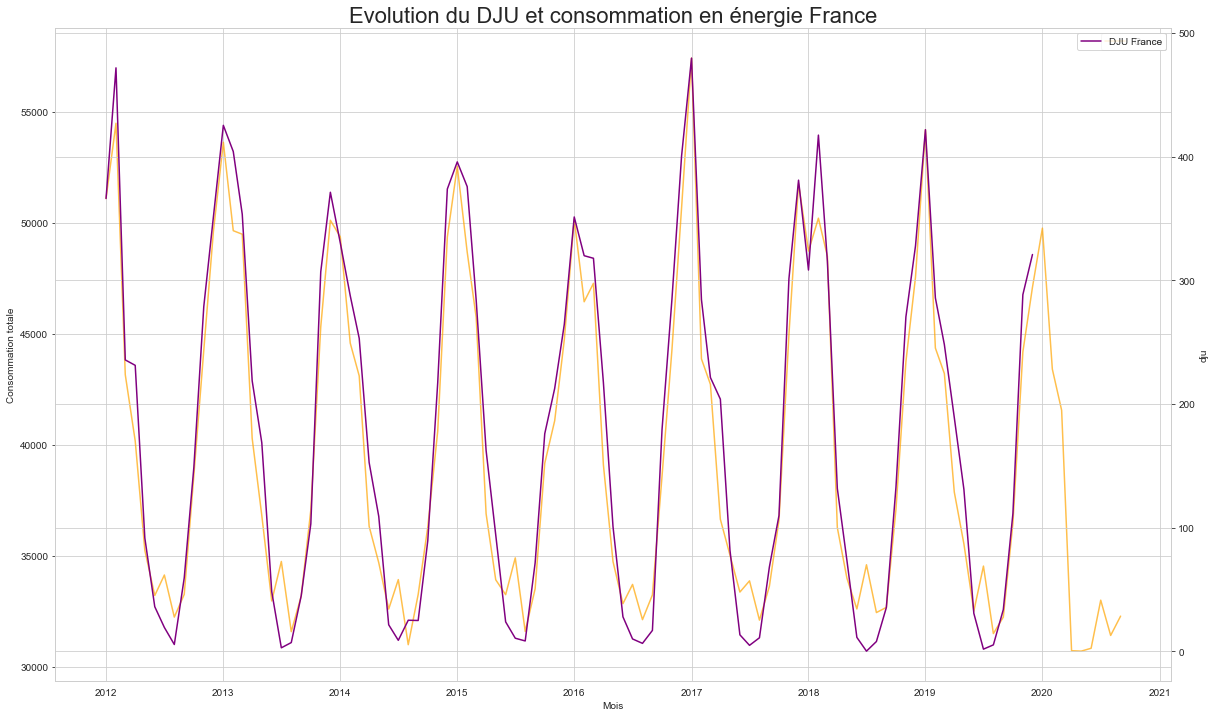

In [22]:
fig = plt.figure(figsize=(20,12))
ax1 = sns.lineplot(data=df_conso_france, x=df_conso_france.index,  y="Consommation totale", color="orange", alpha=0.7, legend='brief', label="Conso")
ax2 = plt.twinx()
ax2 = sns.lineplot(data=df_dju_full_france, x=df_dju_full_france.index,  y="dju", color="purple", ax=ax2, legend='brief', label="DJU France")
plt.title("Evolution du DJU et consommation en énergie France", fontsize=22)
plt.show()

Les 2 courbes semblent suivre la même saisonnalité ce qui indique bien que **les variations de la courbe de consommation d'énergie sont effectivement globalement liées aux écarts de températures**.

<div id="q1" style="float:left; padding:5px; background: black; width:100%; border-bottom: 2px solid #e3a51a;"><img src="assets/logo_small.png" style="float:left; margin-right:10px; height:40px"/><h1 style="float:left; margin-top:10px; color:white; font-family:Helvetica; font-variant: small-caps;">Correction des données de l'effet température</h1></div>

Pour répondre aux questions et traiter les timeseries, **nous allons travailler sur les données France**. Nous créons donc un dataframe global pour analyse.

In [23]:
datas = pd.merge(df_dju_full_france, df_conso_france.reset_index().rename(columns={"Mois":"Periode"}), on="Periode", how="left").set_index("Periode")
datas = datas.rename(columns = {"Consommation totale":"Conso"})
datas

,dju,Territoire,Qualité,Conso
Periode,,,,
2012-01-01,366.325000,France,Données définitives,51086
2012-02-01,471.958333,France,Données définitives,54476
2012-03-01,235.766667,France,Données définitives,43156
2012-04-01,231.400000,France,Données définitives,40176
2012-05-01,91.775000,France,Données définitives,35257
...,...,...,...,...
2019-08-01,5.333333,France,Données consolidées,31505
2019-09-01,33.858333,France,Données consolidées,32248
2019-10-01,111.591667,France,Données consolidées,36482


In [24]:
datas.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96 entries, 2012-01-01 to 2019-12-01
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dju         96 non-null     float64
 1   Territoire  96 non-null     object 
 2   Qualité     96 non-null     object 
 3   Conso       96 non-null     int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 3.8+ KB


In [25]:
datas.describe()

,dju,Conso
count,96.000000,96.000000
mean,179.478646,40030.791667
std,143.171890,7093.466001
min,0.258333,31004.000000
25%,33.102083,33696.750000
50%,165.666667,37082.500000
75%,302.785417,45417.250000
max,479.825000,57406.000000


Pour corriger les données de consommation mensuelles de l'effet température *(dues au chauffage électrique)*, nous allons utiliser une régression linéaire.
Regardons dans un premier temps le scatter plot correspondant à :
- **$X$** = dju
- **$Y$** = consommation totale

Dans ce modèle, nous supposons qu'il existe une **relation linéaire entre la variable à expliquer et la variable explicative** : 

<span style="font-size:18px">$$Y = a + bX + \varepsilon $$</span>

Nous cherchons donc les paramètres inconnus $a$ et $b$ pour corriger les consommations mensuelles de l'effet de température.

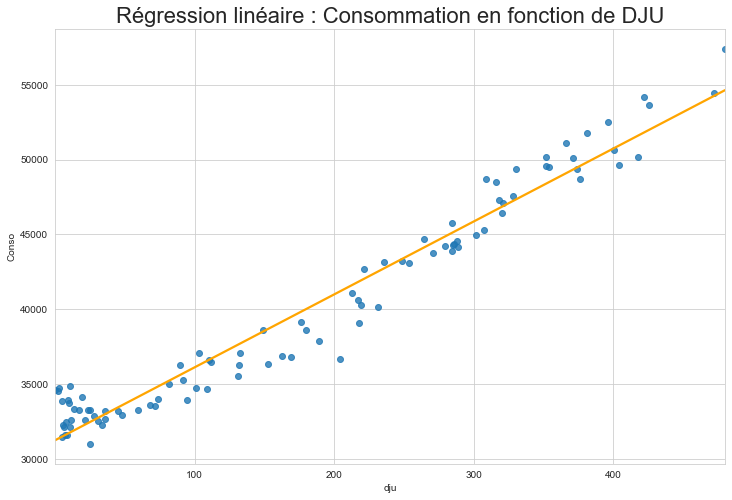

In [26]:
fig = plt.figure(figsize=(12,8))
ax = sns.regplot(data=datas, x="dju", y="Conso", robust=True, ci=None, line_kws={"color":"orange"})
plt.title("Régression linéaire : Consommation en fonction de DJU", fontsize=22)
plt.show()

Réalisons à présent la régression linéaire simple grâce à la **librairie Statsmodels** :

In [27]:
import statsmodels.formula.api as smf

In [28]:
reg_conso = smf.ols('Conso ~ dju', data=datas).fit()
print(reg_conso.summary())

                            OLS Regression Results                            
Dep. Variable:                  Conso   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     1959.
Date:                Mon, 16 Nov 2020   Prob (F-statistic):           9.63e-65
Time:                        12:33:57   Log-Likelihood:                -838.93
No. Observations:                  96   AIC:                             1682.
Df Residuals:                      94   BIC:                             1687.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.134e+04    250.567    125.095      0.0

In [29]:
a, b = reg_conso.params
print("a =",a,"| b =",b)

a = 31344.50955260327 | b = 48.39730138219127


Ici, **le $R^2$ est de l'ordre de 0.95**, ce qui est relativement élévé et au vu de la représentation graphique de notre droite de régression, cela nous indique que le modèle est bon. 
La variable *"dju"* est également statistiquement significative au niveau de test 5%, sa **P-value étant de 0**.

Les coeffiscients de regressions sont ici estimés :
- $a = 31344$
- $b = 48.39$

**Nous allons également représenter les valeurs ajustées en fonction des valeurs observées** :

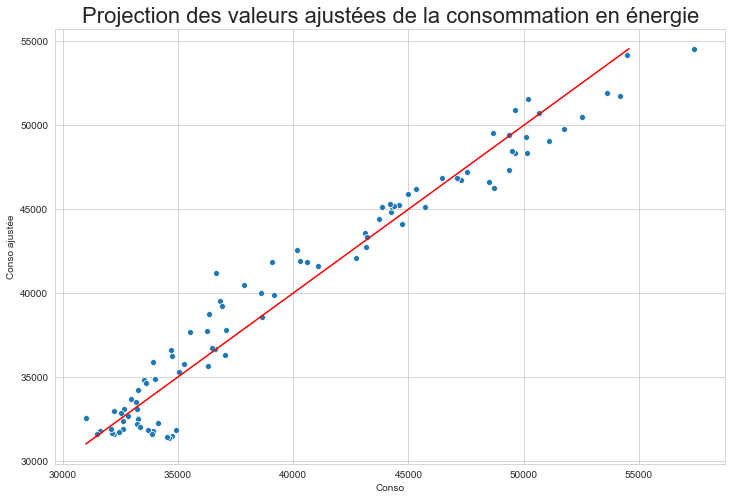

In [30]:
datas['Conso_ajuste'] = reg_conso.predict()

X_plot = [datas['Conso'].min(), datas['Conso_ajuste'].max()]

fig = plt.figure(figsize=(12,8))
ax = sns.scatterplot(x="Conso", y="Conso_ajuste", data=datas)
ax.set(xlabel='Conso', ylabel='Conso ajustée')
plt.plot(X_plot, X_plot, color='r')
plt.title("Projection des valeurs ajustées de la consommation en énergie", fontsize=22)
plt.show()

On remarque que les points projetés sont proches de la première bissectrice, ce qui nous indique que les valeurs ajustées sont proches des valeurs réélles. Notre modèle semble correct. 

Enfin, nous allons **représenter les résidus, $\varepsilon$ étant un paramètre de notre modèle**. Nous allons vérifier qu'ils sont bien centrés et de variance constante.

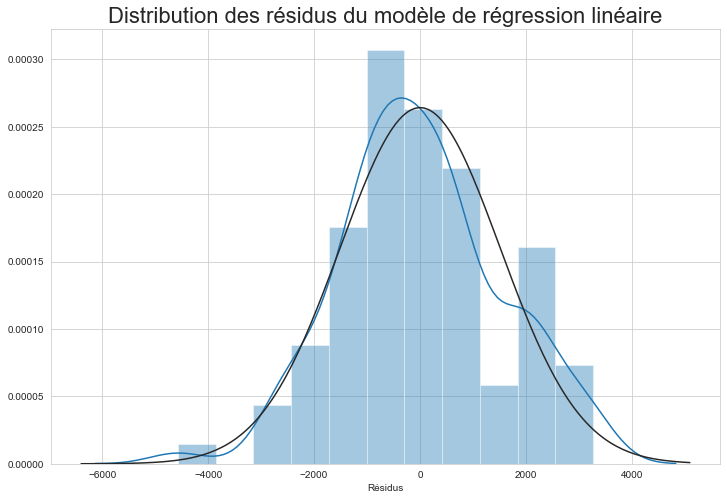

In [31]:
from scipy.stats import norm, shapiro

fig = plt.figure(figsize=(12,8))
ax = sns.distplot(reg_conso.resid, fit=norm)
plt.xlabel('Résidus')
plt.title("Distribution des résidus du modèle de régression linéaire", fontsize=22)
plt.show()

On remarque donc que la distribution des résidus semble centrée et suivent une loi gaussienne. Nous allons réaliser un test de Shapiro-Wilk pour confirmer ce dernier point :

In [32]:
shapiro_test = shapiro(reg_conso.resid)
shapiro_test.pvalue

0.3269602954387665

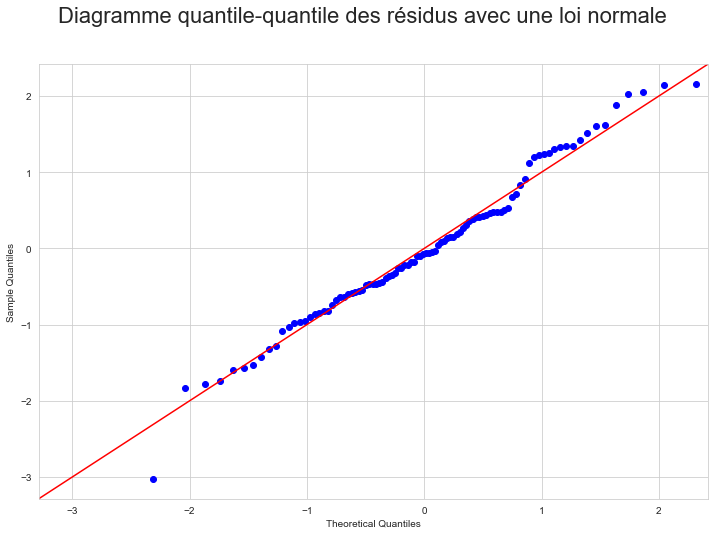

In [33]:
fig = sm.qqplot(reg_conso.resid, fit=True, line="45")
fig.set_size_inches(12, 8)
fig.suptitle("Diagramme quantile-quantile des résidus avec une loi normale", fontsize=22)
plt.show()

La P-value est ici non significative au niveau de test 5%. **Les résidus suivent donc une loi normale** comme nous le constatons également sur le QQPlot.

Les tests sur notre modèles de régression linéaire étant significatifs, nous allons pouvoir utiliser les coeffiscients obtenus pour corriger notre consommation d'énergie des effets de la température :

$$Conso_{ajustée} = Conso -(dju * b)$$

In [34]:
datas['Conso_ajuste'] = datas['Conso'] - (datas['dju']*b)

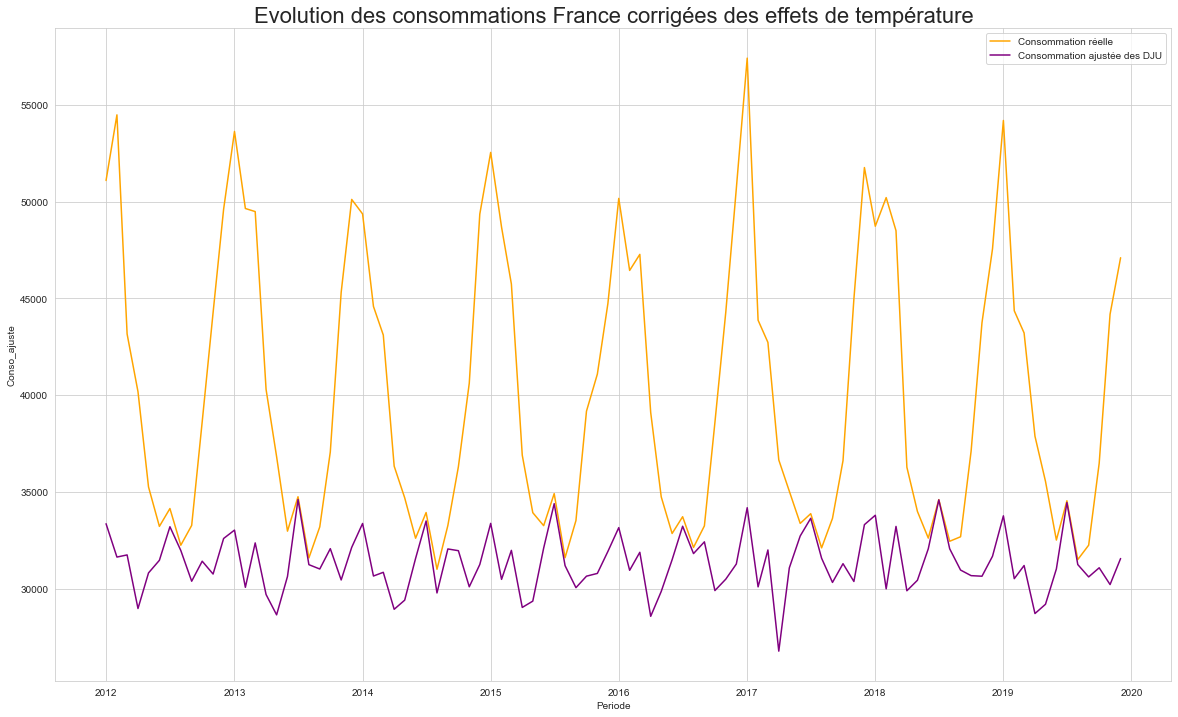

In [35]:
fig = plt.figure(figsize=(20,12))
ax1 = sns.lineplot(data=datas, x=datas.index,  y="Conso", color="orange", legend='brief', label="Consommation réelle")
ax2 = sns.lineplot(data=datas, x=datas.index,  y="Conso_ajuste", color="purple", legend='brief', label="Consommation ajustée des DJU")
plt.title("Evolution des consommations France corrigées des effets de température", fontsize=22)
plt.show()

On voit ici clairement l'impact des températures sur les consommation d'énergie au niveau national. Il existe encore sur cette série temporelle corrigée un fort impact saisonnier.

Nous allons donc effectuer une **désaisonnalisation de la consommation corrigée des effets de température par la méthode des moyennes mobiles**.

<div id="q2" style="float:left; padding:5px; background: black; width:100%; border-bottom: 2px solid #e3a51a;"><img src="assets/logo_small.png" style="float:left; margin-right:10px; height:40px"/><h1 style="float:left; margin-top:10px; color:white; font-family:Helvetica; font-variant: small-caps;">Désaisonnalisation par moyennes mobiles</h1></div>

Une moyenne mobile est une combinaison linéaire d'instants passés et futurs de notre série temporelle. L'enjeu est de trouver une moyenne mobile qui laisse la **tendance invariante**, qui **absorbe la saisonnalité** et qui **réduit le résidu** : 

Notre série temporelle : <span style="font-size:18px">$X_t = T_t + S_t + \varepsilon_t$</span>

Si on applique une moyenne mobile $𝑀$ sur la série, nous obtenons : <span style="font-size:18px">$MX_t = MT_t + MS_t + M\varepsilon_t$</span>

Ses propriétés idéales seront donc :
- $MT_t = T_t$
- $MS_t = 0$
- $M\varepsilon_t$ faible

Ici, nous allons utiliser la fonction **"seasonal_decompose" du package statsmodels** :

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose

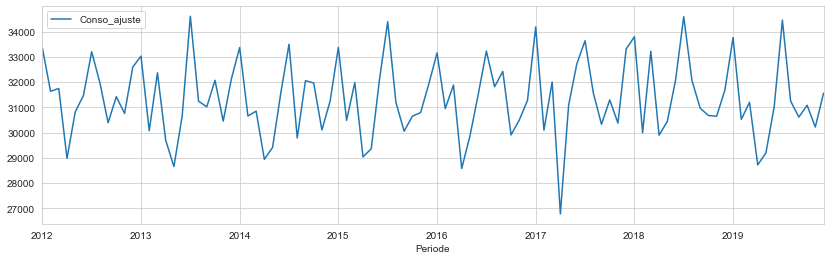

In [37]:
datas.plot(y="Conso_ajuste", figsize=(14,4))

Cette série temporelle semble être un modèle additif. Nous allons donc travailler avec le **logarithme de la variable "Conso_ajuste"** :

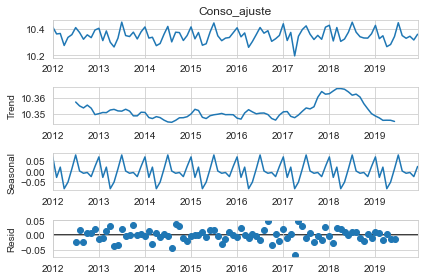

In [38]:
x = datas["Conso_ajuste"]
y = np.log(x)
decomp_y = seasonal_decompose(y,  model='additive')
decomp_y.plot()
plt.show()

On peut voir sur ce graphique combiné la décomposition de la tendance et de la saisonnalité ainsi que les résidus.
Nous allons placer les valeurs de la décomposition dans un dataframe Pandas :

In [39]:
df_decomp_y_seasonal = pd.DataFrame(decomp_y.seasonal)
y_compl = pd.merge(y, df_decomp_y_seasonal, on="Periode")
y_compl["cvs"] = np.exp(y_compl["Conso_ajuste"] - y_compl["seasonal"])
y_compl

,Conso_ajuste,seasonal,cvs
Periode,,,
2012-01-01,10.415019,0.069027,31132.006781
2012-02-01,10.362003,-0.029015,32565.795695
2012-03-01,10.365507,0.020048,31115.424052
2012-04-01,10.274253,-0.083164,31489.737321
2012-05-01,10.335768,-0.051737,32451.578833
...,...,...,...
2019-08-01,10.349675,0.001511,31199.692567
2019-09-01,10.329061,-0.009322,30896.021802
2019-10-01,10.344360,-0.005621,31256.479821


Projetons à présent les **données corrigées des variations saisonnières** ***(CVS)*** :

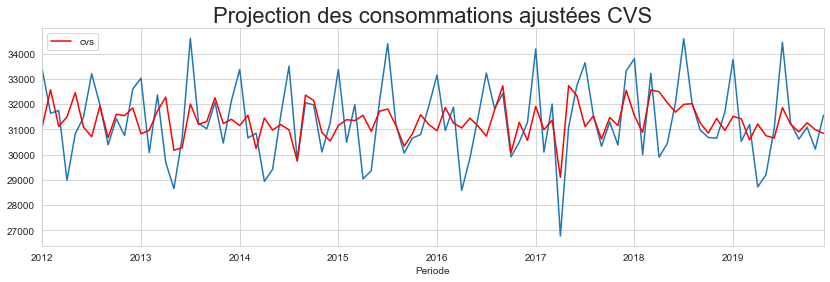

In [40]:
x.plot(figsize=(14,4))
#Plot des valeurs obtenues par CVS des moyennes mobiles
y_compl["cvs"].plot(legend = True, color="r")
plt.title("Projection des consommations ajustées CVS", fontsize=22)
plt.show()

Nous allons ajouter les valeurs de la **consommation ajustée des effets et la température et corrigée des variations saisonnières** à notre dataset initial afin de pouvoir les travailler ensuite.

In [41]:
datas["Conso_ajuste_cvs"] = y_compl["cvs"]
datas

,dju,Territoire,Qualité,Conso,Conso_ajuste,Conso_ajuste_cvs
Periode,,,,,,
2012-01-01,366.325000,France,Données définitives,51086,33356.858571,31132.006781
2012-02-01,471.958333,France,Données définitives,54476,31634.490302,32565.795695
2012-03-01,235.766667,France,Données définitives,43156,31745.529577,31115.424052
2012-04-01,231.400000,France,Données définitives,40176,28976.864460,31489.737321
2012-05-01,91.775000,France,Données définitives,35257,30815.337666,32451.578833
...,...,...,...,...,...,...
2019-08-01,5.333333,France,Données consolidées,31505,31246.881059,31199.692567
2019-09-01,33.858333,France,Données consolidées,32248,30609.348037,30896.021802
2019-10-01,111.591667,France,Données consolidées,36482,31081.264477,31256.479821


In [42]:
datas.to_csv("datas/conso_ajustee.csv", index=True)

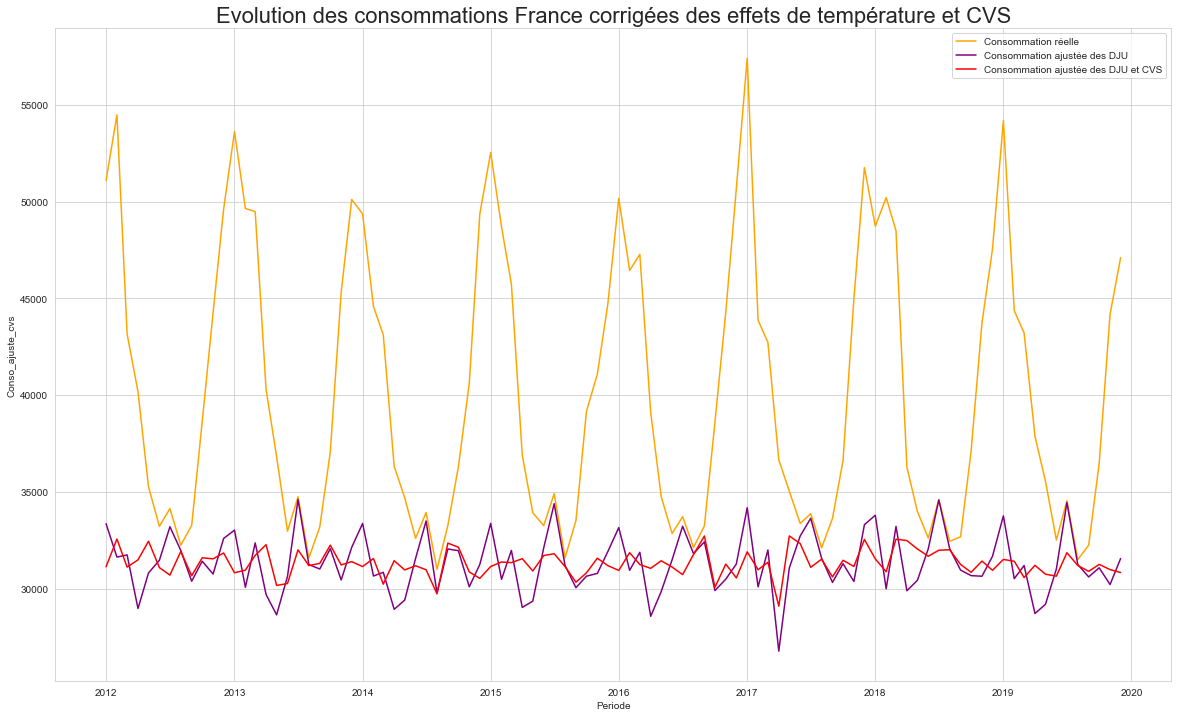

In [43]:
fig = plt.figure(figsize=(20,12))
ax1 = sns.lineplot(data=datas, x=datas.index,  y="Conso", color="orange", legend='brief', label="Consommation réelle")
#ax1.lines[0].set_linestyle("--")
ax2 = sns.lineplot(data=datas, x=datas.index,  y="Conso_ajuste", color="purple", legend='brief', label="Consommation ajustée des DJU")
ax3 = sns.lineplot(data=datas, x=datas.index,  y="Conso_ajuste_cvs", color="red", legend='brief', label="Consommation ajustée des DJU et CVS")
plt.title("Evolution des consommations France corrigées des effets de température et CVS", fontsize=22)
plt.show()

<div id="q3" style="float:left; padding:5px; background: black; width:100%; border-bottom: 2px solid #e3a51a;"><img src="assets/logo_small.png" style="float:left; margin-right:10px; height:40px"/><h1 style="float:left; margin-top:10px; color:white; font-family:Helvetica; font-variant: small-caps;">Prévision de la consommation</h1></div>

## <font color="#e3a51a" style="font-family:Helvetica; font-variant: small-caps;" id="q3-1">Méthode de Holt-Winters (lissage exponentiel)</font>

La méthode de Holt-Winters est une méthode de lissage exponentiel, basé sur les instants passés. Elle consiste à supposer que  $𝑋_𝑡$ est approximable au voisinage de $𝑇$ par $𝑎_𝑇+(𝑡−𝑇)𝑏_𝑇+𝑆_𝑇$. En désignant par $𝑠$ la période du cycle saisonnier de la série temporelle.

**Pour cette prévision, nous allons utiliser la série corrigée des effets de température** :

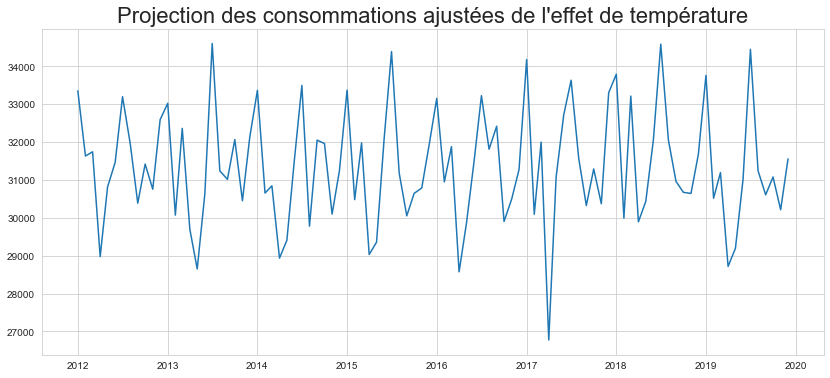

In [44]:
plt.figure(figsize=(14,6))
plt.plot(datas['Conso_ajuste'], label='Consommation ajustée des effets de température')
plt.title("Projection des consommations ajustées de l'effet de température", fontsize=22)
plt.show()

Nous allons travailler sur la série de 2012 à 2018 afin de tenter de prévoir l'année 2019 pour comparer la prévision au données réelles.    
Nous utiliserons la fonction ExponentialSmoothing de Statsmodels :

In [45]:
x_train = x["2012":"2018"]
x_test = x["2019"]
y_train = np.log(x_train)
y_test = np.log(x_test)

In [46]:
from statsmodels.tsa.api import ExponentialSmoothing
hw_ln = ExponentialSmoothing(np.asarray(y_train), seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred_ln = hw_ln.forecast(12)

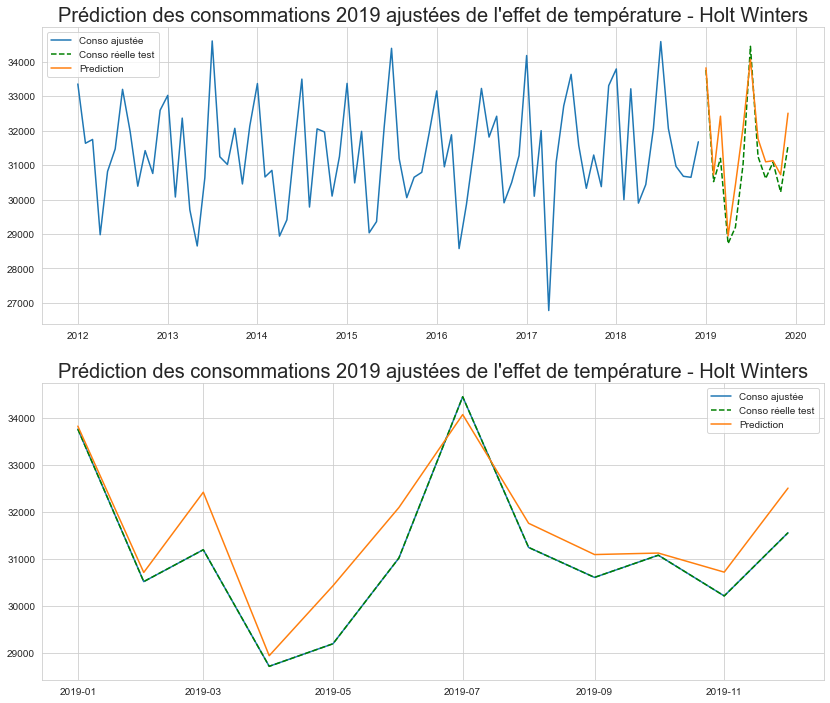

In [47]:
plt.figure(figsize=(14,12))
plt.subplot(211)
plt.plot(x_train, label='Conso ajustée')
plt.plot(x_test, label='Conso réelle test', color="g", linestyle="--")
plt.plot(y_test.index, np.exp(hw_pred_ln), label='Prediction')
plt.title("Prédiction des consommations 2019 ajustées de l'effet de température - Holt Winters", fontsize=20)
plt.legend()

#Zoom
plt.subplot(212)
plt.plot(x["2019":], label='Conso ajustée')
plt.plot(x_test, label='Conso réelle test', color="g", linestyle="--")
plt.plot(y_test.index, np.exp(hw_pred_ln), label='Prediction')
plt.title("Prédiction des consommations 2019 ajustées de l'effet de température - Holt Winters", fontsize=20)
plt.legend()

plt.show()

La prédiction pour 2019 avec **la méthode de Holt Winters est relativement fidèle aux données réelles**. La saisonnalité et la tendance sont représentatives. Nous allons ensuite réaliser cette prédiction avec une méthode SARIMA.

**A présent, regardons les métriques principales du modèle** :

#### RMSE (Root Mean Square Error) :
Le critère RMSE se caractérise par la moyenne des carrés des écarts entre les données prédites et les données réelles. C'est de fait une mesure globale de l'exactitude du modèle. Plus la valeur du RMSE est proche de 0, meilleur est le modèle en terme d'exactitude. 

#### MAPE (Mean Average Percentage Error)
Erreur relative absolue moyenne.

In [48]:
#Fonction de calculs des metriques importantes MAE, MSE, MAPE, RMSE, R²
def metrics_timeseries(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    diff = y_true - y_pred
    mae = np.mean(abs(diff))
    mse = np.mean(diff**2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs(diff / y_true)) * 100
    r2 = 1-(sum(diff**2)/sum((y_true-np.mean(y_true))**2))
    dict_metrics = {"Métrique":["MAE", "MSE", "RMSE", "MAPE", "R²"], "Résultats":[mae, mse, rmse, mape, r2]}
    df_metrics = pd.DataFrame(dict_metrics)
    return df_metrics

In [49]:
df_metrics_holt_winters = metrics_timeseries(np.exp(y_test), np.exp(hw_pred_ln))
df_metrics_holt_winters

,Métrique,Résultats
0,MAE,574.707289
1,MSE,506040.406414
2,RMSE,711.365171
3,MAPE,1.865724
4,R²,0.792255


## <font color="#e3a51a" style="font-family:Helvetica; font-variant: small-caps;" id="q3-2">Méthode SARIMA</font>

Les modèles SARIMA *(Seasonnal AutoRegressive Integrated Moving Average)* permettent de modéliser des séries qui présentent une saisonnalité, comme c'est le cas pour notre dataset.

Dans un premier temps, nous allons **tester la stationnarité de notre série avec le test ADF** *(Augmented Dickey-Fuller)*.     
L'hypothèse nulle du test est que la série temporelle n'est pas stationnaire.

In [50]:
from statsmodels.tsa.stattools import adfuller, acf, pacf

In [51]:
#ADF-test(Série originelle)
res_adf_o = adfuller(x,regression='ct')
print('p-value ADF série originelle :{}'.format(res_adf_o[1]))

p-value ADF série originelle :0.4084295754097529


In [52]:
#ADF-test(Série différenciée)
res_adf_d = adfuller(x.diff().dropna(),regression='c')
print('p-value ADF série différenciée :{}'.format(res_adf_d[1]))

p-value ADF série différenciée :2.2508365429056965e-08


**Au niveau de test 5%, on ne rejette pas l'hypothèse de non-stationnarité de la série**, contrairement à la série différenciée.     
Nous allons donc devoir effectuer une stationnarisation.

### <font color="purple" style="font-family:Helvetica; font-variant: small-caps;">Stationnarisation de la série</font>
Nous allons réaliser cette **stationnarisation par différenciation** de manière itérative si besoin. Nous allons travailler sur le logarithme de la série, comme pour la méthode de Holt-Winters.

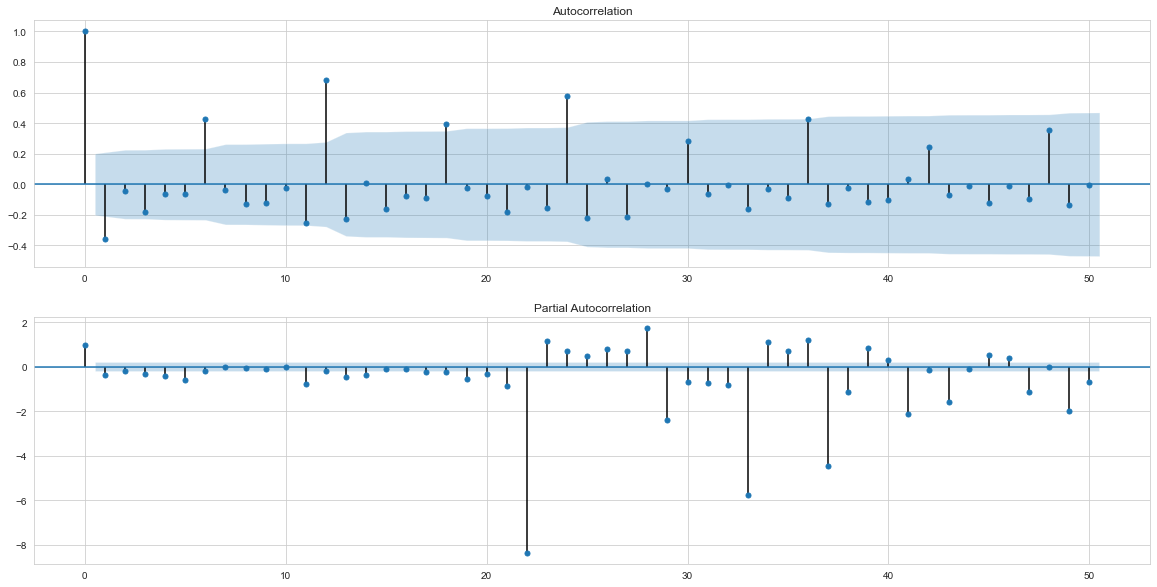

In [53]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(y.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(y.diff().dropna(), lags=50, ax=ax[1])
plt.show()

Comme on peut le voir, il y a des pics significatifs dans le graphique ACF au décalage 6, 12, 18 ... *(composante saisonnière semestrielle)*. Dans le graphique PACF, les délais sont plus lents à se désintégrer autour de 22, 32, ainsi que des pics négatifs significatifs.     
Ces caractéristiques suggèrent un point de départ potentiel des paramètres de $SARIMA(1,1,0)(1,1,1,6)$

- p et P sont tous deux égaux à 1 (Pics positifs significatifs dans les graphiques ACF et PACF) 
- d et D sont tous deux égaux à 1 (différenciation a effectuer sur les premiers paramètres et les saisonniers) 
- q = 0 et Q = 1 (pics négatifs significatifs sur le PACF mais pas forcement sur ACF) 
- s égal à 6 (composante saisonnière semestrielle)

Nous allons effectuer dans un premier temps une différenciation $(𝐼−𝐵^{6})$

In [54]:
y_diff_6 = y.diff(6)

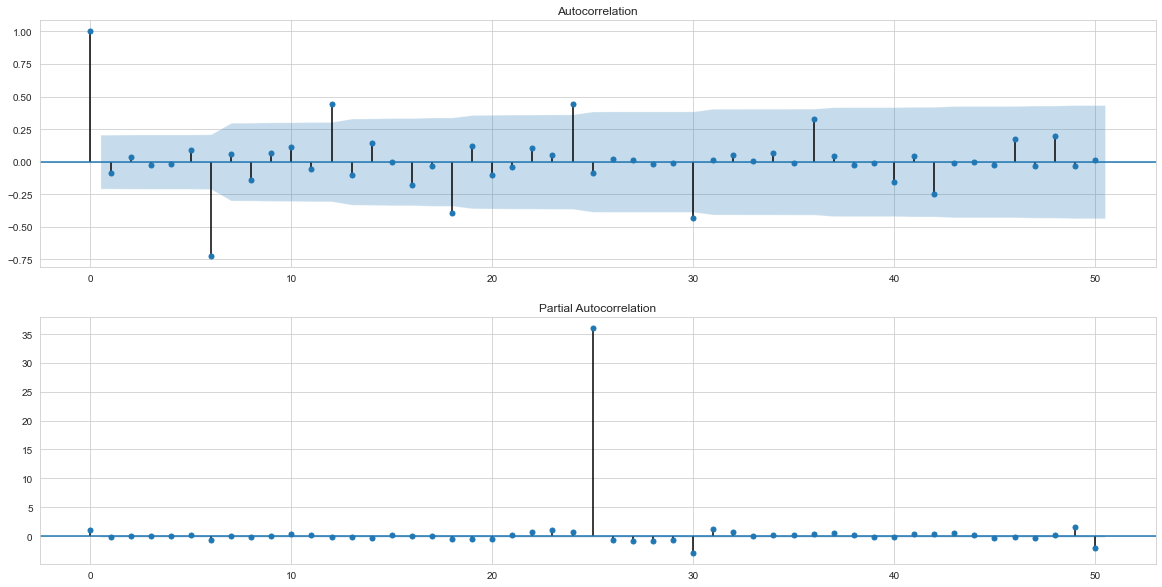

In [55]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(y_diff_6.dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(y_diff_6.dropna(), lags=50, ax=ax[1])
plt.show()

Il existe encore un problème de stationarité pour les multiples de 12 selon les autocorrélogrammes. Nous allons donc effectuer une seconde différenciation $(𝐼−𝐵^{12})$ sur cette série différenciée.

In [56]:
y_diff_6_12 = y_diff_6.diff(12)

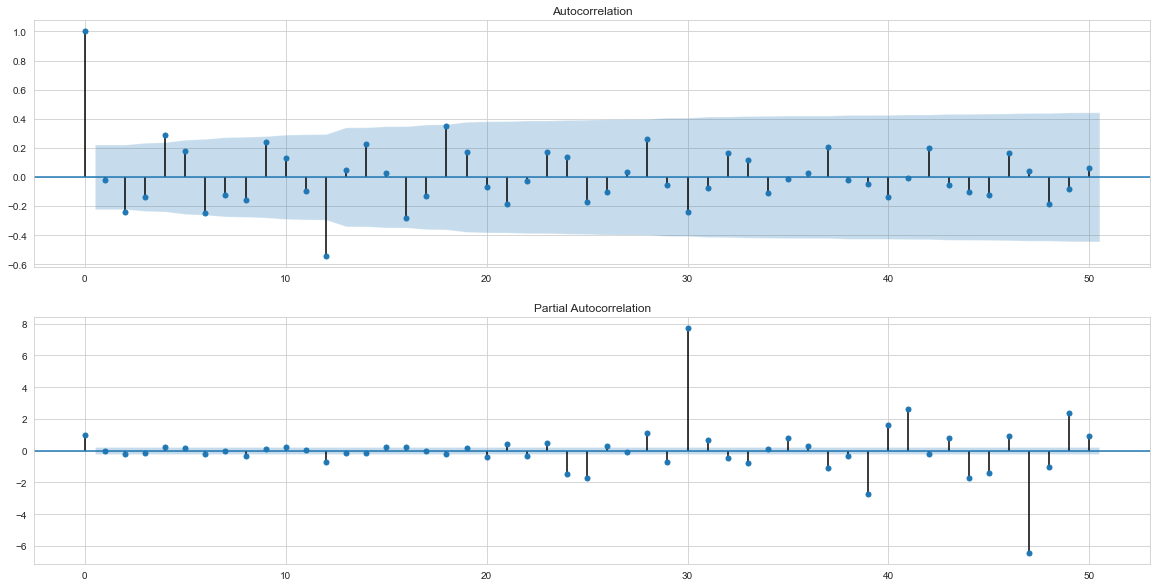

In [57]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(y_diff_6_12.dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(y_diff_6_12.dropna(), lags=50, ax=ax[1])
plt.show()

### <font color="purple" style="font-family:Helvetica; font-variant: small-caps;">Estimation et validation des modèles</font>

Comme demandé, nous allons réaliser la modélisation avec un modèle SARIMA :

In [58]:
from statsmodels.tsa.statespace.sarimax import *
from statsmodels.stats.diagnostic import acorr_ljungbox

model1 = SARIMAX(np.asarray(y), order=(1,1,0), seasonal_order=(1,1,1,6))
results1 = model1.fit()
residus1 = results1.resid
print(results1.summary())

print('\nTEST DE JUNG-BOX - (Test de blancheur)\n\nRetard : p-value')
for elt in np.arange(6,50,6):
    print('{} : {}'.format(elt, acorr_ljungbox(results1.resid, lags=elt)[1].mean()))

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   96
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 6)   Log Likelihood                 164.403
Date:                             Mon, 16 Nov 2020   AIC                           -320.806
Time:                                     12:34:29   BIC                           -310.851
Sample:                                          0   HQIC                          -316.793
                                              - 96                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5126      0.068     -7.513      0.000      -0.646      -0.379
ar.S.L6       -0.3196      

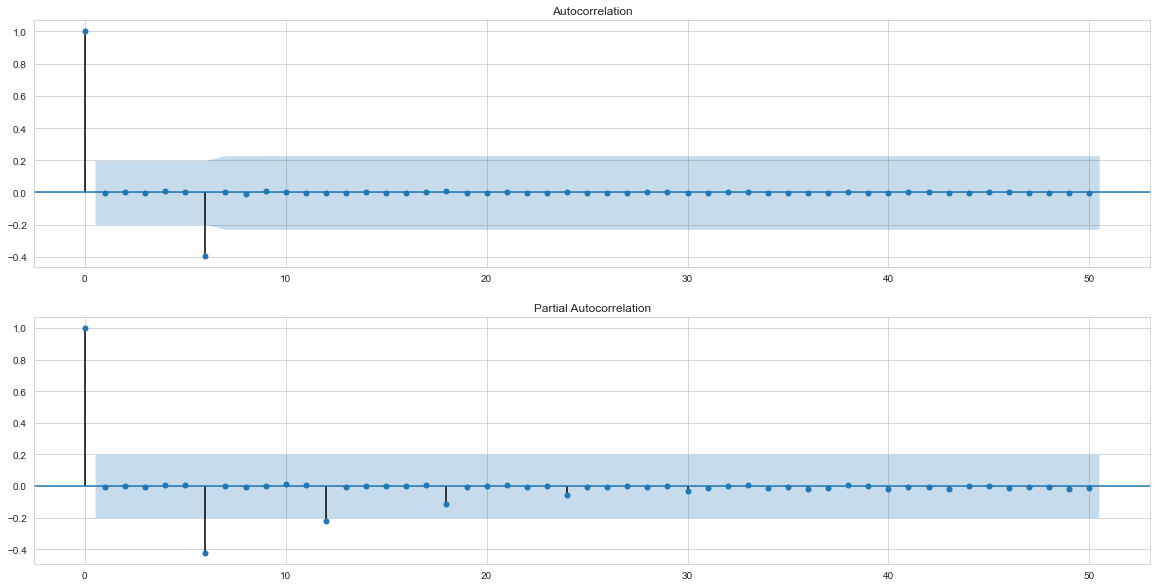

In [59]:
fig, ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(residus1, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(residus1, lags=50, ax=ax[1])
plt.show()

**Les tests de significativité des paramètres et de blancheur du résidu sont validés au niveau 5%**. De  plus, sur les graphiques ACF et PACF des résidus, il n'y a pas de pics fortement significatifs mais il existe tout de même des variations.

In [60]:
shapiro(residus1)

ShapiroResult(statistic=0.16124123334884644, pvalue=6.728095655430961e-21)

Le **test de normalité est également validé** pour ce modèle.     
Nous allons à présent éditer les plots de diagnostique du modèle :

In [61]:
def plot_diagnostics(sarima_res, variable=0, lags=10, fig=None, figsize=None):
        return type(sarima_res.plot_diagnostics(variable, lags, fig, figsize))

matplotlib.figure.Figure

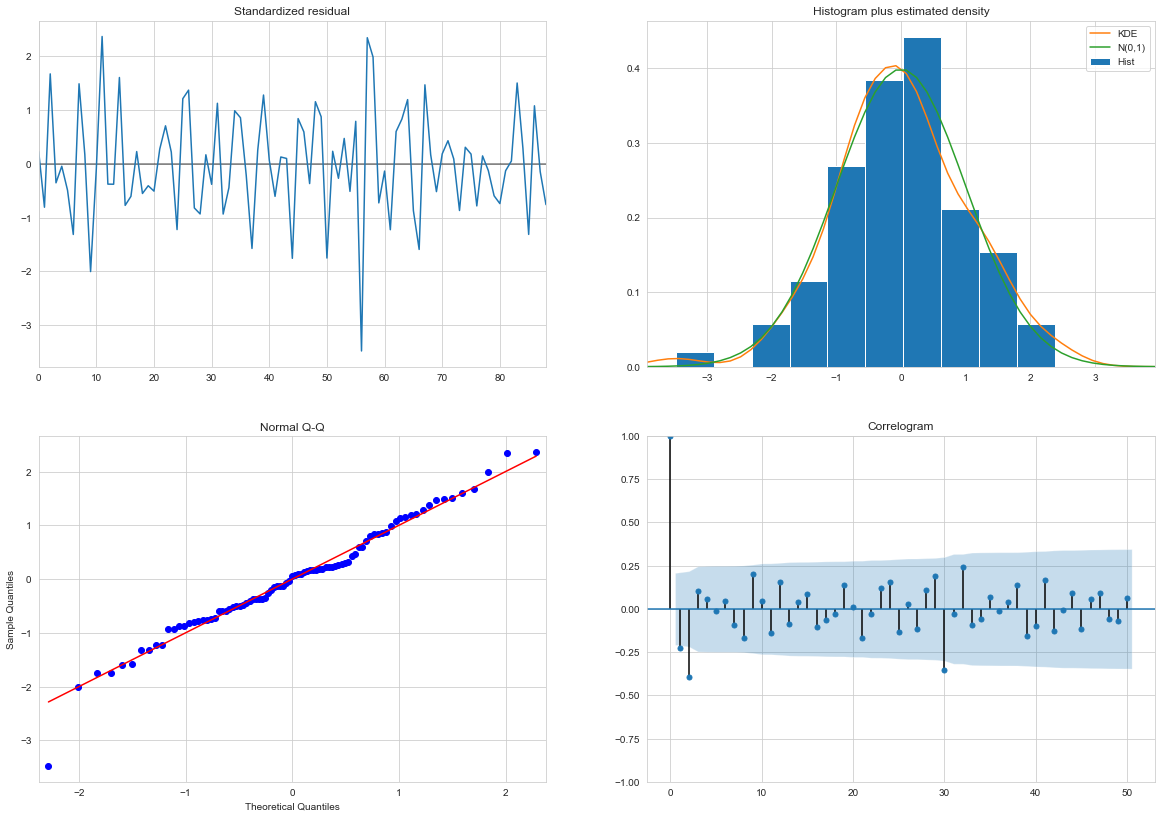

In [62]:
plot_diagnostics(sarima_res = results1, figsize=(20,14), lags=50)

On rermarque donc ici que les résidus sont bien un bruit blanc et leur normalité est également validée. Le modèle semble donc performant, mais nous allons réaliser une **Grid Search** pour vérifier les autres paramètres avant de **pouvoir effectuer nos tests à posteriori**.

```python
df_results_gs = pd.DataFrame(columns=["Modèle","AIC","MAPE","RMSE","MSE","MAE"])

def grid_search_sarima(season, y_train, y_test):
# Define the p, d and q parameters to take any value between 0 and 2
    configs = list()
    # Liste des config
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = season

    for p in p_params:
        for d in d_params:
            for q in q_params:
                for P in P_params:
                    for D in D_params:
                        for Q in Q_params:
                            for m in m_params:
                                cfg = [(p,d,q), (P,D,Q,m)]
                                configs.append(cfg)

    list_model = list()
    list_aic = list()
    list_mape = list()
    list_rmse = list()
    list_mse = list()
    list_mae = list()

    for config_sarima in configs:
        order, seasonal_order = config_sarima
        try:
            model = sm.tsa.statespace.SARIMAX(y_train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit(disp=False)
            pred_model = results.get_forecast(12)
            pred = pred_model.predicted_mean
      
            #metriques
            y_true, y_pred = np.array(np.exp(y_test)), np.array(np.exp(pred))
            diff = y_true - y_pred
            mae = np.mean(abs(diff))
            mse = np.mean(diff**2)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs(diff / y_true)) * 100
            #print('SARIMA{}x{} - AIC:{} - MAPE:{}'.format(order, seasonal_order, results.aic, mape))

            str_model = str(order) + str(seasonal_order)
            list_model.append(str_model)
            list_aic.append(results.aic)
            list_mape.append(mape)
            list_rmse.append(rmse)
            list_mse.append(mse)
            list_mae.append(mae)

        except:
            continue

    df_results_gs["Modèle"] = list_model
    df_results_gs["AIC"] = list_aic
    df_results_gs["MAPE"] = list_mape
    df_results_gs["RMSE"] = list_rmse
    df_results_gs["MSE"] = list_mse
    df_results_gs["MAE"] = list_mae

    return df_results_gs

grid_search_sarima([6,12],y_train,y_test)
```

In [63]:
df_grid_search = pd.read_csv("datas/grid_search_sarima.csv").sort_values(by="AIC")
df_grid_search.head(10)

,Modèle,AIC,MAPE,RMSE,MSE,MAE
13,"(0, 0, 0)(1, 0, 1, 6)",-301.511986,5.089872,2029.446401,4.118653e+06,1584.582025
14,"(0, 0, 0)(1, 0, 1, 12)",-301.407048,5.276942,2090.174227,4.368828e+06,1643.523347
211,"(1, 0, 0)(1, 0, 1, 6)",-301.032681,5.110580,2038.027806,4.153557e+06,1590.673210
212,"(1, 0, 0)(1, 0, 1, 12)",-300.267310,5.294939,2098.259807,4.402694e+06,1648.913627
26,"(0, 0, 0)(2, 0, 2, 6)",-298.834790,5.202683,2070.464604,4.286824e+06,1620.577209
410,"(2, 0, 0)(1, 0, 1, 12)",-298.560774,5.334164,2107.345140,4.440904e+06,1660.159641
224,"(1, 0, 0)(2, 0, 2, 6)",-298.227155,5.181111,2066.572004,4.270720e+06,1613.856567
245,"(1, 0, 1)(1, 0, 1, 12)",-297.186752,5.379354,2122.615116,4.505495e+06,1673.192328
422,"(2, 0, 0)(2, 0, 2, 6)",-296.674288,5.184953,2063.936267,4.259833e+06,1614.319825
257,"(1, 0, 1)(2, 0, 2, 6)",-295.204714,5.229659,2073.964084,4.301327e+06,1626.548827


Toujours en fonction des premiers autocorrélogrammes et des résultats obtenus dans cette grid search, **Nous allons tester le modèles qui semble avoir les meilleures métriques et un AIC significatif :**
- (1, 0, 1)(1, 0, 1, 12)

In [64]:
model2 = SARIMAX(np.asarray(y), order=(1,0,1), seasonal_order=(1,0,1,12))
results2 = model2.fit()
residus2 = results2.resid
print(results2.summary())

print('\nTEST DE JUNG-BOX - (Test de blancheur)\n\nRetard : p-value')
for elt in np.arange(6,50,6):
    print('{} : {}'.format(elt, acorr_ljungbox(results2.resid, lags=elt)[1].mean()))

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   96
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 198.169
Date:                            Mon, 16 Nov 2020   AIC                           -386.338
Time:                                    12:34:39   BIC                           -373.516
Sample:                                         0   HQIC                          -381.155
                                             - 96                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.000   8639.939      0.000       1.000       1.000
ma.L1         -0.9414      0.065   

Le **modèle 2 semble plus performant** en tous points, nous allons réaliser les tests sur ce dernier :

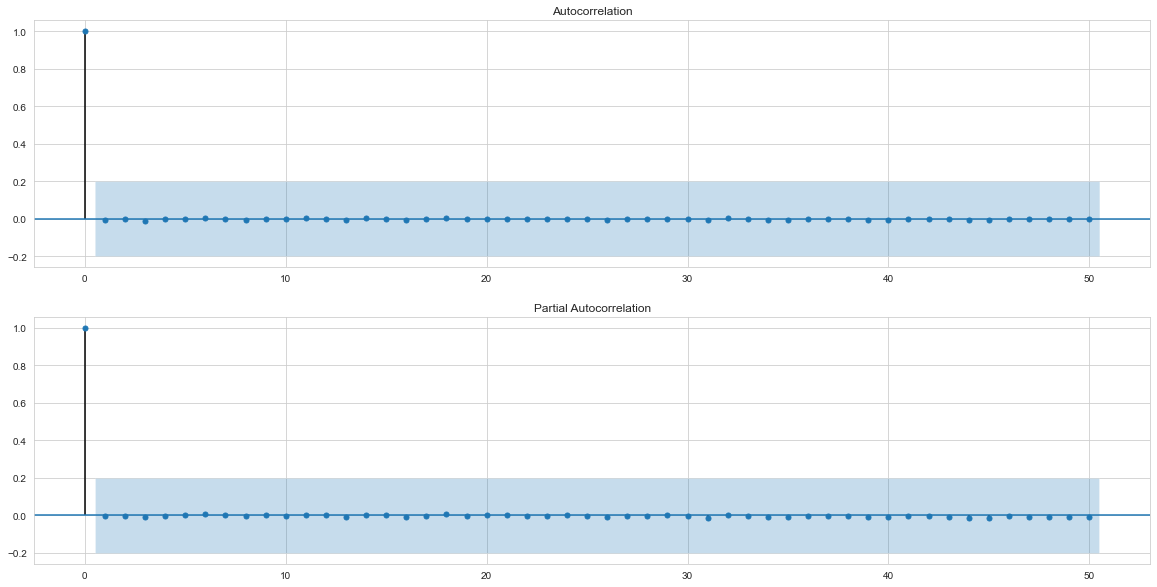

In [65]:
fig, ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(residus2, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(residus2, lags=50, ax=ax[1])
plt.show()

matplotlib.figure.Figure

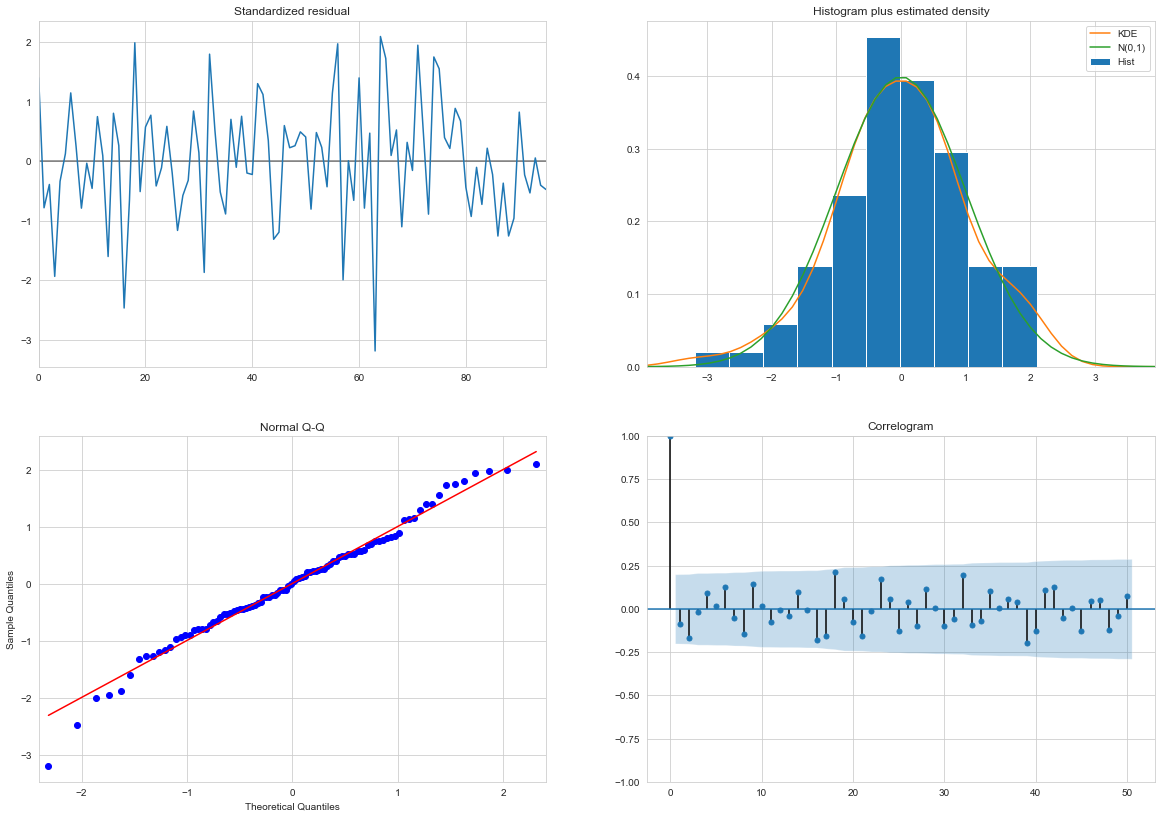

In [66]:
plot_diagnostics(sarima_res = results2, figsize=(20,14), lags=50)

On remarque **sur ce second modèle des indicateurs encore meilleurs que sur le modèle 1**. Le test de blancheur présente des p-values proches de 1 et les indicateurs de performance tels que l'AIC sont satisfaisant. La normalité des résidus est également confirmée.    
Nous utiliserons donc le modèle 2 pour nos analyses à posteriori.

### <font color="purple" style="font-family:Helvetica; font-variant: small-caps;">Analyse à posteriori</font>

Nous allons à nouveau utiliser le split de notre série temporelle pour obtenir un jeu de test et un jeu d'entrainement. Nous pourrons ensuite estimer notre prévision comparativement aux données réelles.

Vérifions si notre modèle est toujours optimal sur nos données d'entrainement :

In [67]:
model_train = SARIMAX(np.asarray(y_train), order=(1,0,1), seasonal_order=(1,0,1,12))
results_train = model_train.fit()
print(results_train.summary())

print('\nTEST DE JUNG-BOX - (Test de blancheur)\n\nRetard : p-value')
for elt in np.arange(6,50,6):
    print('{} : {}'.format(elt, acorr_ljungbox(results_train.resid, lags=elt)[1].mean()))
    
print("\nTEST DE SHAPIRO (normalité des résidus)\n",shapiro(results_train.resid))

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   84
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 168.325
Date:                            Mon, 16 Nov 2020   AIC                           -326.651
Time:                                    12:34:49   BIC                           -314.497
Sample:                                         0   HQIC                          -321.765
                                             - 84                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.000   6573.720      0.000       1.000       1.000
ma.L1         -0.9532      0.075   

matplotlib.figure.Figure

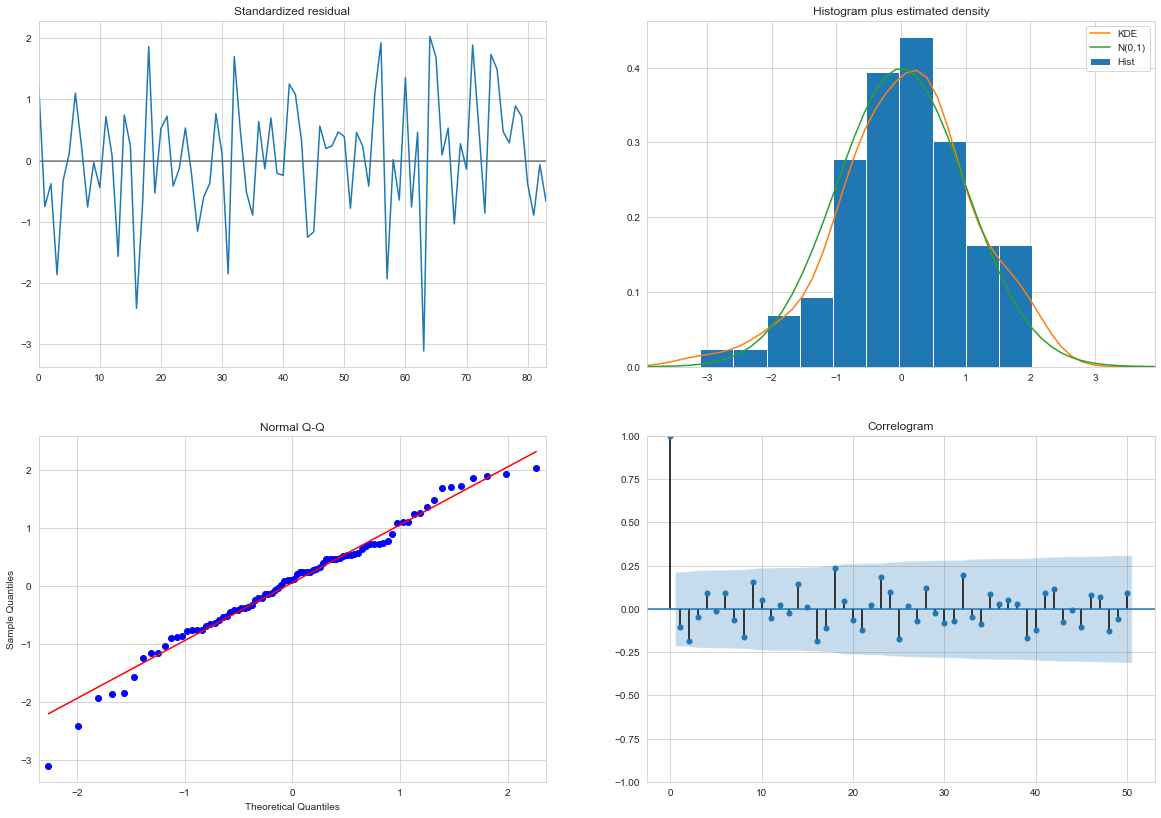

In [68]:
plot_diagnostics(sarima_res = results_train, figsize=(20,14), lags=50)

Ce modèle est bien validé sur notre série d'entrainement.     
**Réalisons à présent la prédiction** :

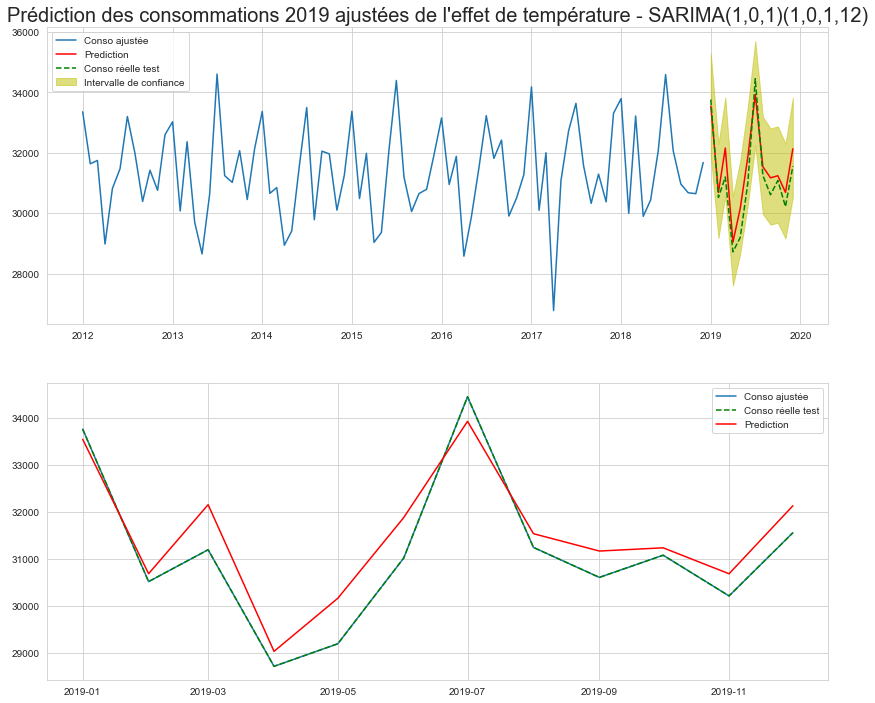

In [69]:
pred_model = results_train.get_forecast(12)
pred = pred_model.predicted_mean
#Intervals de prévisions à 5%
pred_ci = pred_model.conf_int(alpha=0.05)

plt.figure(figsize=(14,12))
plt.subplot(211)
plt.plot(x_train, label='Conso ajustée')
plt.plot(y_test.index, np.exp(pred), color='r', label='Prediction')
plt.plot(np.exp(y_test), label='Conso réelle test', color="g", linestyle="--")
plt.fill_between(y_test.index, np.exp(pred_ci[:,0]), np.exp(pred_ci[:,1]), alpha=0.5, color="y", label="Intervalle de confiance")
plt.title("Prédiction des consommations 2019 ajustées de l'effet de température - SARIMA(1,0,1)(1,0,1,12)", fontsize=20)
plt.legend()

#Zoom
plt.subplot(212)
plt.plot(x["2019":], label='Conso ajustée')
plt.plot(x_test, label='Conso réelle test', color="g", linestyle="--")
plt.plot(y_test.index, np.exp(pred), color='r', label='Prediction')
plt.legend()

plt.show()

**On calcule les métriques pour SARIMA** :

In [70]:
df_metrics_SARIMA = metrics_timeseries(np.exp(y_test), np.exp(pred))
df_metrics_SARIMA

,Métrique,Résultats
0,MAE,505.762125
1,MSE,335280.939659
2,RMSE,579.034489
3,MAPE,1.636208
4,R²,0.862357


On peut égalerment obtenir cet indicateur via les fonctions de Statsmodels :

In [71]:
sm.tools.eval_measures.rmse(np.exp(y_test), np.exp(pred))

579.0344891794548

In [72]:
df_compare_metrics = pd.merge(df_metrics_holt_winters, df_metrics_SARIMA, on="Métrique").rename(columns={"Résultats_x":"Résultats HW","Résultats_y":"Résultats SARIMA"})
df_compare_metrics

,Métrique,Résultats HW,Résultats SARIMA
0,MAE,574.707289,505.762125
1,MSE,506040.406414,335280.939659
2,RMSE,711.365171,579.034489
3,MAPE,1.865724,1.636208
4,R²,0.792255,0.862357


Si l'on regarde ces différentes métriques, **le modèle SARIMA semble être meilleur que le HOLT-WINTERS** pour cette série temporelle.

## <font color="#e3a51a" style="font-family:Helvetica; font-variant: small-caps;" id="pred_fin">Prévision des consommations pour l'année 2020.</font>

Mantenant que nos modèles Holt-Winters et SARIMA ont été testés, nous allons pouvoir effectuer cette prédiction pour 2020 *(données inconnues de l'algorithme)* :

 ### <font color="purple" style="font-family:Helvetica; font-variant: small-caps;">Méthode de Holt-Winters</font>

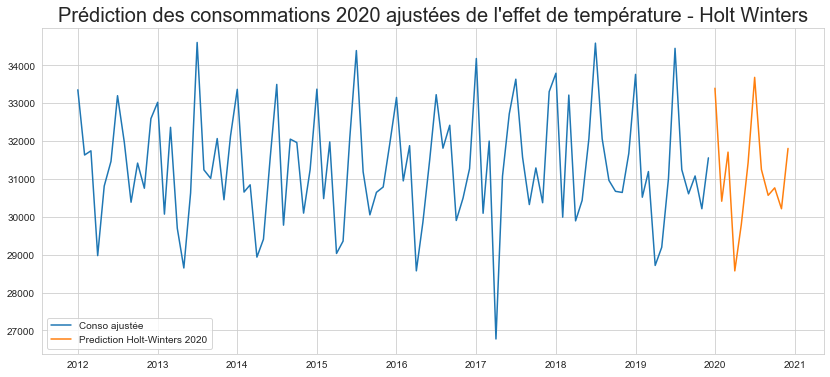

In [73]:
hw_ln_2020 = ExponentialSmoothing(np.asarray(y), seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred_ln_2020 = hw_ln_2020.forecast(12)

plt.figure(figsize=(14,6))
plt.plot(x, label='Conso ajustée')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), np.exp(hw_pred_ln_2020), label='Prediction Holt-Winters 2020')
plt.title("Prédiction des consommations 2020 ajustées de l'effet de température - Holt Winters", fontsize=20)
plt.legend()
plt.show()

### <font color="purple" style="font-family:Helvetica; font-variant: small-caps;">Méthode SARIMA</font>

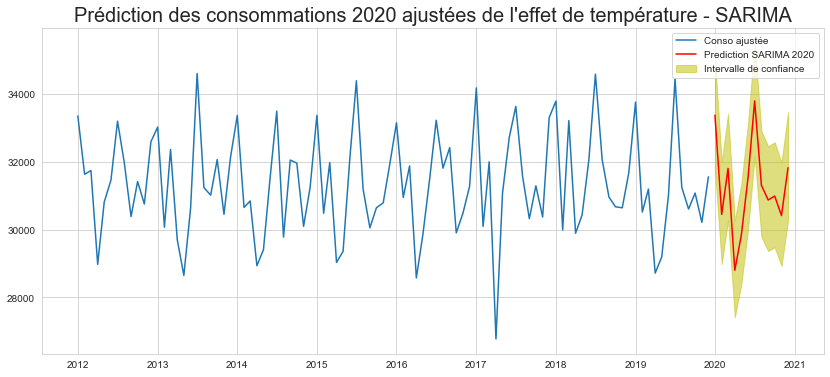

In [74]:
pred_model_2020 = results2.get_forecast(12)
pred_2020 = pred_model_2020.predicted_mean
#Intervals de prévisions à 5%
pred_ci_2020 = pred_model_2020.conf_int(alpha=0.05)

plt.figure(figsize=(14,6))
plt.plot(x, label='Conso ajustée')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), np.exp(pred_2020), color='r', label='Prediction SARIMA 2020')
plt.fill_between(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), np.exp(pred_ci_2020[:,0]), 
                 np.exp(pred_ci_2020[:,1]), alpha=0.5, color="y", label="Intervalle de confiance")
plt.title("Prédiction des consommations 2020 ajustées de l'effet de température - SARIMA", fontsize=20)
plt.legend()
plt.show()

### <font color="purple" style="font-family:Helvetica; font-variant: small-caps;">Comparaison des 2 méthodes</font>

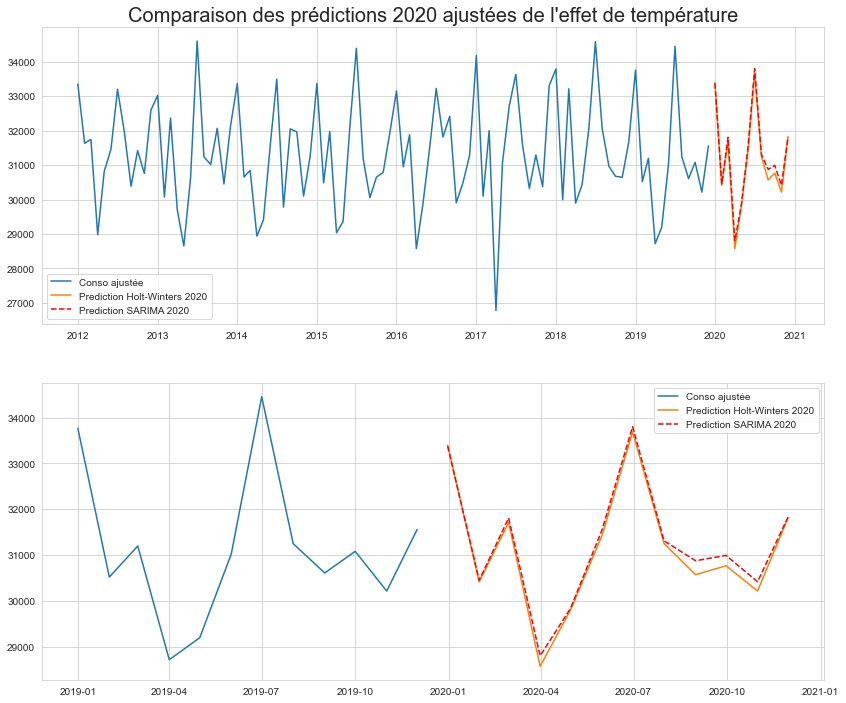

In [75]:
plt.figure(figsize=(14,12))
plt.subplot(211)
plt.plot(x, label='Conso ajustée')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), np.exp(hw_pred_ln_2020), label='Prediction Holt-Winters 2020')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), np.exp(pred_2020), color='r', linestyle="--", label='Prediction SARIMA 2020')
plt.title("Comparaison des prédictions 2020 ajustées de l'effet de température", fontsize=20)
plt.legend()

#Zoom
plt.subplot(212)
plt.plot(x["2019":], label='Conso ajustée')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), np.exp(hw_pred_ln_2020), label='Prediction Holt-Winters 2020')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), np.exp(pred_2020), color='r', linestyle="--", label='Prediction SARIMA 2020')
plt.legend()

plt.show()